In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# Reloading any code written in external .py files.
%load_ext autoreload
%autoreload 2

import datetime
import glob
import os

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
n_epochs = 5
batch_size_train = 64
batch_size_test = 100
learning_rate = 0.01
momentum = 0.5
log_interval = 100

random_seed = 1
torch.manual_seed(random_seed)

# check if CUDA is available
device = torch.device("cpu")
if torch.cuda.is_available():
    print('CUDA is available!  Training on GPU ...')
    device = torch.device("cuda")
else:
    print('CUDA is not available.  Training on CPU ...')

CUDA is available!  Training on GPU ...


In [7]:
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('/data/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
    batch_size=batch_size_train, shuffle=True, pin_memory=True)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('/data/', train=False, download=True,
                         transform=torchvision.transforms.Compose([
                           torchvision.transforms.ToTensor(),
                           torchvision.transforms.Normalize(
                             (0.1307,), (0.3081,))
                         ])),
    batch_size=batch_size_test, shuffle=True, pin_memory=True)

In [8]:
class DenseNet(nn.Module):
    def __init__(self):
        super(DenseNet, self).__init__()
        self.dens1 = nn.Linear(784, 256)
        self.relu1 = nn.ReLU()
        self.drop1 = nn.Dropout(0.2)
        self.dens2 = nn.Linear(256, 128)
        self.relu2 = nn.ReLU()
        self.drop2 = nn.Dropout(0.2)
        self.dens3 = nn.Linear(128, 64)
        self.relu3 = nn.ReLU()
        self.drop3 = nn.Dropout(0.2)
        self.dens4 = nn.Linear(64, 20)
        self.relu4 = nn.ReLU()
        self.drop4 = nn.Dropout(0.2)
        self.dens5 = nn.Linear(20, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.dens1(x)
        x = self.relu1(x)
        x = self.drop1(x)
        x = self.dens2(x)
        x = self.relu2(x)
        x = self.drop2(x)
        x = self.dens3(x)
        x = self.relu3(x)
        x = self.drop3(x)
        x = self.dens4(x)
        x = self.relu4(x)
        x = self.drop4(x)
        x = self.dens5(x)
        return F.log_softmax(x, dim=1)
    
    def extract_outputs(self, x, layer, neuron=None):
        outputs = []
        
        def hook(module, input, output):
            outputs.append(output)    
            
        for name, module in self.named_children():
            if name == layer:
                handle = module.register_forward_hook(hook)   
                
        out = self(x)
        
        if not neuron is None:
            outputs[0] = outputs[0][0][neuron]
   
        handle.remove()
  
        return outputs

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.relu2 = nn.ReLU()
        self.fc1 = nn.Linear(4 * 4 * 50, 500)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = F.max_pool2d(x, 2, 2)
        x = self.conv2(x)
        x = self.relu2(x)
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4 * 4 * 50)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
    
    def extract_outputs(self, x, layer, neuron=None):
        outputs = []      
        def hook(module, input, output):
            outputs.append(output)    
        for name, module in self.named_children():
            if name == layer:
                handle = module.register_forward_hook(hook)     
        out = self(x)
        if not neuron is None:
            outputs[0] = outputs[0][0][neuron]
        else:
            outputs[0] = outputs[0][0]
        handle.remove()
        return outputs
  
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        # calculate robust loss
        loss = F.cross_entropy(model(data), target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                       100. * batch_idx / len(train_loader), loss.item()))
            
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [9]:
retrain = False
track_low_high = False

model = ConvNet().to(device)
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

# check to see if we can just load a previous model
# %mkdir models
latest_model = None
m_type = model.__class__.__name__
prev_models = glob.glob('pretrained_models/mnist/*'+ m_type +'*.pth')
if prev_models:
    latest_model = max(prev_models, key=os.path.getctime)

if (retrain is False 
    and latest_model is not None 
    and m_type in latest_model):  
    print('loading model', latest_model)
    model.load_state_dict(torch.load(latest_model))  
else:
    if track_low_high:
        model.init_dict(model.lowhigh_dict, inputs, 'relu', {'low': 0, 'high': 0})
        try:
            for epoch in range(1, n_epochs + 1):
                model.hook_lowhigh_dict('relu')
                train(model, device, train_loader, optimizer, epoch)
                model.remove_hooks()
                test(model, device, test_loader)    
        finally:
            model.remove_hooks()   
    else:
        for epoch in range(1, n_epochs + 1):
            train(model, device, train_loader, optimizer, epoch)
            acc = test(model, device, test_loader)  
    torch.save(model.state_dict(), 'pretrained_models/mnist/model_' + m_type + '_' + str(datetime.datetime.now()).replace(':','.') + '_' + str(acc) + '.pth')

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.300039
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.437823
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.366197
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.324132
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.223611
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.338487
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.063627
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.114942
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.144618
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.117394

Test set: Average loss: 0.1022, Accuracy: 9657/10000 (97%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.148142
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.103152
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.059494
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.065197
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.119787
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.034771
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.034602
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.038330
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.028553
T

FileNotFoundError: [Errno 2] No such file or directory: 'pretrained_models/mnist/model_ConvNet_2019-07-31 19.16.28.445851_None.pth'

In [10]:
dataloader = test_loader # the dataloader (of type torch.utils.data.DataLoader)
mean = (0.1307,) # the mean used in inputs normalization
std = (0.3081,) # the standard deviation used in inputs normalization

In [19]:
inputs, targets = next(iter(dataloader))

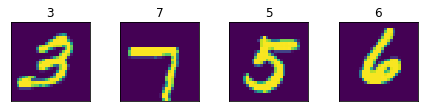

In [20]:
num_samples = 4
for i in range(1,num_samples+1):
    plt.subplot(1, num_samples, i)
    plt.imshow(np.squeeze(inputs[i].numpy()))
    plt.title(targets[i].item())
    plt.tight_layout()
    plt.xticks([])
    plt.yticks([])
    
plt.show()

In [15]:
%cd ..

C:\Users\Fabrice\Dropbox\UCLA\research\19 Summer\diversity attacks\cw attack


In [32]:
device = torch.device("cpu")

model = model.to(device)
inputs = inputs.to(device)
targets = targets.to(device)

cpu cpu


In [33]:
import cw

inputs_box = (min((0 - m) / s for m, s in zip(mean, std)),
              max((1 - m) / s for m, s in zip(mean, std)))

# an untargeted adversary
adversary = cw.L2Adversary(targeted=False,
                           confidence=0.0,
                           search_steps=10,
                           box=inputs_box,
                           optimizer_lr=5e-4)

inputs, targets = next(iter(dataloader))

adversarial_examples = adversary(model, inputs, targets, to_numpy=False)
assert isinstance(adversarial_examples, torch.FloatTensor)
assert adversarial_examples.size() == inputs.size()

# # a targeted adversary
# adversary = cw.L2Adversary(targeted=True,
#                            confidence=0.0,
#                            search_steps=10,
#                            box=inputs_box,
#                            optimizer_lr=5e-4)

# inputs, targets = next(iter(dataloader))
# # a batch of any attack targets
# attack_targets = torch.ones(inputs.size(0)) * 3 # target is 3
# adversarial_examples = adversary(model, inputs, attack_targets, to_numpy=False)
# assert isinstance(adversarial_examples, torch.FloatTensor)
# assert adversarial_examples.size() == inputs.size()

Step 0 Using scale consts: [0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001]
batch [0] loss: 0.8916170597076416
batch [10] loss: 0.892185628414154
batch [20] loss: 0.89176344871521
batch [30] loss: 0.8915929794311523
batch [40] loss: 0.8915765881538391
batch [50] loss: 0.8915737271308899
batch [60] loss: 0.8915719985961914
batch [70] loss: 0.89157

Step 4 Using scale consts: [10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 6.25e-05, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0]
batch [0] loss: 8142.20654296875
batch [10] loss: 7973.3115234375
batch [20] loss: 7790.81005859375
batch [30] loss: 7641.19091796875
batch [40] loss: 7518.7177734375
batch [50] loss: 7416.2548828125
batch [60] loss: 7327.33642578125
batch [70] loss: 7248.7470703125
batch [80] loss: 7179.0205078125
batch [90] loss: 7115.89599609375
batch [100] loss: 7057.80908203125

batch [10] loss: 32363.38671875
batch [20] loss: 31429.25
batch [30] loss: 30735.771484375
batch [40] loss: 30130.212890625
batch [50] loss: 29798.634765625
batch [60] loss: 29525.57421875
batch [70] loss: 29282.279296875
batch [80] loss: 29062.08984375
batch [90] loss: 28858.4921875
batch [100] loss: 28732.6953125
batch [110] loss: 28618.314453125
batch [120] loss: 28508.666015625
batch [130] loss: 28403.3984375
batch [140] loss: 28302.056640625
batch [150] loss: 28203.86328125
batch [160] loss: 28109.88671875
batch [170] loss: 28020.796875
batch [180] loss: 27935.73828125
batch [190] loss: 27853.4375
batch [200] loss: 27773.630859375
batch [210] loss: 27697.33203125
batch [220] loss: 27622.384765625
batch [230] loss: 27552.365234375
batch [240] loss: 27485.33203125
batch [250] loss: 27420.6640625
batch [260] loss: 27358.798828125
batch [270] loss: 27297.791015625
batch [280] loss: 27238.79296875
batch [290] loss: 27181.396484375
batch [300] loss: 27125.21484375
batch [310] loss: 2707

batch [110] loss: 6243.0908203125
batch [120] loss: 6241.1474609375
batch [130] loss: 6239.17138671875
batch [140] loss: 6237.05615234375
batch [150] loss: 6234.9384765625
batch [160] loss: 6232.8857421875
batch [170] loss: 6230.8798828125
batch [180] loss: 6228.86962890625
batch [190] loss: 6226.89404296875
batch [200] loss: 6224.7568359375
batch [210] loss: 6222.8330078125
batch [220] loss: 6220.59814453125
batch [230] loss: 6218.6259765625
batch [240] loss: 6216.5009765625
batch [250] loss: 6214.537109375
batch [260] loss: 6212.3447265625
batch [270] loss: 6210.263671875
batch [280] loss: 6208.2578125
batch [290] loss: 6206.37255859375
batch [300] loss: 6204.18701171875
batch [310] loss: 6202.17822265625
batch [320] loss: 6199.87939453125
batch [330] loss: 6198.04931640625
batch [340] loss: 6195.82373046875
batch [350] loss: 6193.6259765625
batch [360] loss: 6191.697265625
batch [370] loss: 6189.4736328125
batch [380] loss: 6187.32861328125
batch [390] loss: 6185.2294921875
batch [4

Perturbed Accuracy: 0/100 (0%)

Original Accuracy: 99/100 (99%)



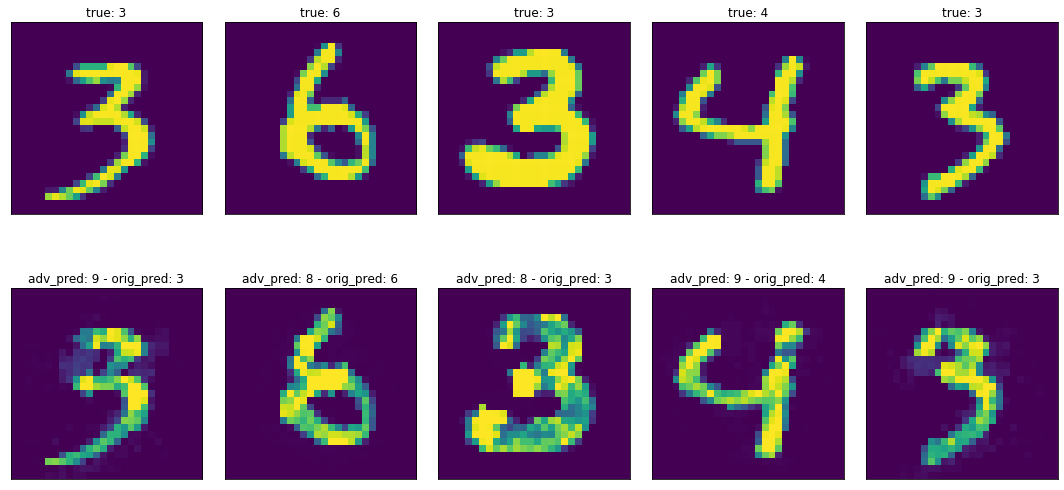

In [34]:
pert_output = model(adversarial_examples)
orig_output = model(inputs)

pert_pred = torch.argmax(pert_output, dim=1)
orig_pred = torch.argmax(orig_output, dim=1)

pert_correct = pert_pred.eq(targets.data).sum()
orig_correct = orig_pred.eq(targets.data).sum()

pert_acc = 100. * pert_correct / len(targets)
orig_acc = 100. * orig_correct / len(targets)

print('Perturbed Accuracy: {}/{} ({:.0f}%)\n'.format(pert_correct, len(targets), pert_acc))
print('Original Accuracy: {}/{} ({:.0f}%)\n'.format(orig_correct, len(targets), orig_acc))

# inputs, adversarial_examples, targets
num_samples = 5

plt.figure(figsize=(15,8))

for i in range(1,num_samples+1):
    
    plt.subplot(2, num_samples, i)
    plt.imshow(np.squeeze(inputs[i].numpy()))  
    plt.title('true: {}'.format(targets[i].item()))
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(2, num_samples, num_samples+i)
    plt.imshow(np.squeeze(adversarial_examples[i].numpy()))
    plt.title('adv_pred: {} - orig_pred: {}'.format(pert_pred[i].item(), orig_pred[i].item()))
    plt.xticks([])
    plt.yticks([])
    

plt.tight_layout()
plt.show()

# Objective Function

$\sum_{i=1}^N LOSS[f(x_i+\delta), y_i] + \lambda \cdot DIVERGENCE[f(x_i+\delta),DISTRIBUTION_{uniform}]$

In [ ]:
def diversity_objective(model, layer, data, target, delta=None, loss_fn=None, regularizer_weight=None):
  
    if loss_fn is None: 
        loss_fn = F.cross_entropy # F.nll_loss, 
    
    if regularizer_weight is None:
        regularizer_weight = 0.005  

    if delta is None:
        # get the dimensions of the input, excluding the batch dimension
        C, N, M = list(data.size()[1:]) # C = channel, N = row, M = column
        delta = torch.rand((C, N, M), requires_grad=True)
    else:
        # required to track gradients wrt the perturbations to the input
        if not delta.requires_grad:
            delta.requires_grad = True
         
    obj = loss_fn(model(data + delta), target) + regularizer_weight * measureKLDivLossAgainstUniform(data + delta, model, layer)
  
    return obj

# Testing area for complete workflow

1. Add hook to model at a given layer
2. Extract activations from a batch of inputs (NOTE: activations are not binarized (0,1), but actual activation outputs (0,))
3. Normalize (softmax them so that they sum to 1) across inputs
4. Normalize a second time across neurons so that you have a density that can be reasonably compared against a uniform distribution
5. Compute the loss